In [1]:
# Author: C. Hull (github: chat.hull)

# This is a project analyzing historical data of the air quality in Santiago, Chile 

# The data for a representative weather station in central Santiago can be found here:
# https://sinca.mma.gob.cl/index.php/estacion/index/key/D14

# Shout-outs to the many posts/github pages that helped me out!
# Julia Kho: web scraping, https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
# Aditya Sharma: time-series moving averages, https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
# Manish Pathak: concatenating/merging in pandas, https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
# Laura Fedoruk: time-series manipulation in pandas, https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
# Facebook Prophet quick-start guide: https://facebook.github.io/prophet/docs/quick_start.html#python-api
# Adding addition regressors to Prophet: https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb
# AQI lookup table: http://www.sparetheair.com/publications/AQI_Lookup_Table-PM25.pdf
# AQI calculation: https://metone.com/how-to-calculate-aqi-and-nowcast-indices/
# timeanddate historical weather data: https://www.timeanddate.com/weather/chile/santiago/historic?month=8&year=2020

In [2]:
%%javascript

// Prevent scrolling with large/multiple plots
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Don't print Prophet stdout
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

In [4]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import requests
from bs4 import BeautifulSoup
import time
import datetime as dt
from datetime import date
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error
from IPython.display import display, Markdown, Latex

In [5]:
# Test if a value is a float
def isfloat(x) :
    try:
        float(x)
        return True
    except:
        return False

In [6]:
# Define rms error (RMSE)
def rmse(values1, values2) :
    return np.sqrt( np.nanmean( (np.array(values1)-np.array(values2))**2 ) )

In [7]:
# Calculate AQI value from concentration
def calcAQI(concentration) :    
    if concentration <= 12.0 :
        BP_hi = 12
        BP_lo = 0
        I_hi = 50
        I_lo = 0
    elif 12.0 < concentration <= 35.4 :
        BP_hi = 35.4
        BP_lo = 12.1
        I_hi = 100
        I_lo = 51
    elif 35.4 < concentration <= 55.4 :
        BP_hi = 55.4
        BP_lo = 35.5
        I_hi = 150
        I_lo = 101
    elif 55.4 < concentration <= 150.4 :
        BP_hi = 150.4
        BP_lo = 55.5
        I_hi = 200
        I_lo = 151
    elif 150.4 < concentration <= 250.4 :
        BP_hi = 250.4
        BP_lo = 150.5
        I_hi = 300
        I_lo = 201
    elif 250.4 < concentration <= 350.4 :
        BP_hi = 350.4
        BP_lo = 250.5
        I_hi = 400
        I_lo = 301
    elif 350.4 < concentration <= 500.4 :
        BP_hi = 500.4
        BP_lo = 350.5
        I_hi = 500
        I_lo = 401
    
    return (I_hi-I_lo)/(BP_hi-BP_lo)*(concentration - BP_lo) + I_lo

In [8]:
# Scrape SINCA website

# Many pollutants, but different stations don't have continuous time coverage of all of them
# SO2, NO, NO2, CO, O3, NOX, non-methanic hydrocarbons, PM10, PM2.5

# For now, focus on PM10, PM2.5, and weather data at the Parque O'Higgins station in central Santiago
station = 'D14'
# Earliest common date is 031215 (constrained by weather data)
date_from = '031215'
# Current date
date_to = date.today().strftime("%y%m%d")

#PM2.5
pm25 = {
    'name' : 'pm2.5',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM25//PM25.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

#PM10
pm10 = {
    'name' : 'pm10',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM10//PM10.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Relative humidity
rhum = {
    'name' : 'rhum',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/RHUM//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Temperature
temp = {
    'name' : 'temp',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/TEMP//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind speed
wspd = {
    'name' : 'wspd',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WSPD//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind direction
wdir = {
    'name' : 'wdir',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WDIR//horario_000_spec.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

In [9]:
def scrapeData(series_url) :
    time.sleep(1)
    response = requests.get(series_url)
    print(response)
    return response

def formatData(html_response) :
    data = html_response.text.split('\n')
    # Clear header and footer text
    data = [ line for line in data if len(line) and isfloat(line[0]) ]
    # Non-ideal way of dealing with column numbers in PM data vs. weather data
    data = [ line+' ,' for line in data ]
    # Keep lines with date; time; and validated, preliminary, or non-validated data (latter two are only in PM datasets)
    # data = [ line.split(',')[0:5] for line in data if isfloat(line.split(',')[2]) or isfloat(line.split(',')[3]) or isfloat(line.split(',')[4]) ]
    # TODO: now keeping all data so that I preserve the timestamp even when there aren't any data (so I can interpolate later)
    data = [ line.split(',')[0:5] for line in data ]
    return data

In [10]:
# Empty dataframe; will merge other columns into it one by one
df_tot = pd.DataFrame(columns=['datetime'])

# Scrape and format data, and produce final pandas dataframe
for series in [pm25, pm10, rhum, temp, wspd, wdir] : 
    response = scrapeData(series['url'])
    data = formatData(response)
    
    # Format dates
    df = pd.DataFrame.from_records(data, columns=['date', 'time', 'validated', 'preliminary', 'non-validated'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%y%m%d %H%M')
    df = df.drop(columns=['date', 'time'])
    
    # Replace white space with NaNs
    df = df.replace(r'^\s+$', np.nan, regex=True)
    # Combine validated, preliminary, and non-validated data columns
    df[series['name']] = df['validated'].combine_first(df['preliminary']).combine_first(df['non-validated'])
    df = df.drop(columns=['validated','preliminary','non-validated'])
    
    # Convert unicode to floats
    df[series['name']] = pd.to_numeric(df[series['name']])
    
    # Merge latest time-series into full DataFrame, resort index
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [11]:
# Today!
today = date.today()

In [12]:
# Strip out ds (datestamp) and pm2.5 (for the y column) for the Prophet prediction
df_prophet = df_tot[['datetime','pm2.5']]
# Rename columns to comply with Prophet naming requirements
df_prophet = df_prophet.rename(columns={'datetime':'ds', 'pm2.5':'y'})
# Set end of the training dataset to be today minus 1 week TODO
#df_prophet = df_prophet[(df_prophet['ds'] <  str(today - dt.timedelta(weeks=1)) )]
# Set end of the training dataset to be today
df_prophet = df_prophet[(df_prophet['ds'] <  str(today) )]
df_prophet.tail()

,ds,y
160434,2022-04-03 19:00:00,11.0
160435,2022-04-03 20:00:00,10.0
160436,2022-04-03 21:00:00,6.0
160437,2022-04-03 22:00:00,8.0
160438,2022-04-03 23:00:00,9.0


In [13]:
# Set datetime column as the index of the dataframe
df_tot = df_tot.set_index('datetime')

In [14]:
df_tot.tail(15)

,pm2.5,pm10,rhum,temp,wspd,wdir
datetime,,,,,,
2022-04-04 09:00:00,26.0,87.0,47.2500,18.7833,0.146181,54.7403
2022-04-04 10:00:00,21.0,81.0,42.3333,21.2000,0.384233,328.6390
2022-04-04 11:00:00,21.0,96.0,37.1667,23.3083,0.492741,139.5380
2022-04-04 12:00:00,22.0,97.0,31.1667,25.4667,0.291762,149.2350
2022-04-04 13:00:00,20.0,75.0,27.0000,26.9818,1.057390,118.4440
2022-04-04 14:00:00,19.0,108.0,27.1667,27.5417,1.719320,116.5940
2022-04-04 15:00:00,12.0,88.0,24.9167,28.2250,1.889290,118.2880
2022-04-04 16:00:00,NaN,NaN,25.3636,27.8000,2.208490,118.1750
2022-04-04 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Interpolate so there are no missing values; assume default method ('linear')
df_tot['pm2.5'] = df_tot['pm2.5'].interpolate()
df_tot['pm10'] = df_tot['pm10'].interpolate()
df_tot['rhum'] = df_tot['rhum'].interpolate()
df_tot['temp'] = df_tot['temp'].interpolate()
df_tot['wspd'] = df_tot['wspd'].interpolate()
df_tot['wdir'] = df_tot['wdir'].interpolate()

In [16]:
# NaNs are now interpolated
df_tot.tail(15)

,pm2.5,pm10,rhum,temp,wspd,wdir
datetime,,,,,,
2022-04-04 09:00:00,26.0,87.0,47.2500,18.7833,0.146181,54.7403
2022-04-04 10:00:00,21.0,81.0,42.3333,21.2000,0.384233,328.6390
2022-04-04 11:00:00,21.0,96.0,37.1667,23.3083,0.492741,139.5380
2022-04-04 12:00:00,22.0,97.0,31.1667,25.4667,0.291762,149.2350
2022-04-04 13:00:00,20.0,75.0,27.0000,26.9818,1.057390,118.4440
2022-04-04 14:00:00,19.0,108.0,27.1667,27.5417,1.719320,116.5940
2022-04-04 15:00:00,12.0,88.0,24.9167,28.2250,1.889290,118.2880
2022-04-04 16:00:00,12.0,88.0,25.3636,27.8000,2.208490,118.1750
2022-04-04 17:00:00,12.0,88.0,25.3636,27.8000,2.208490,118.1750


**The average PM2.5 concentration has been decreasing with time; why hasn't this been on the news?**

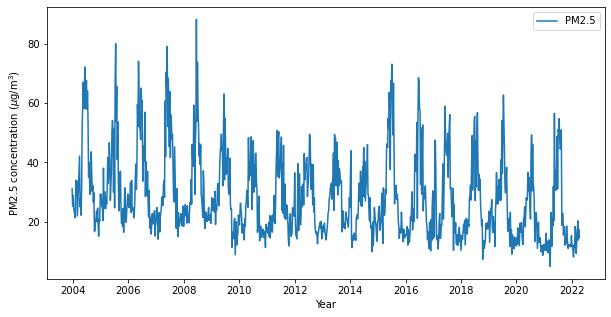

In [31]:
# Sample plot: resampled (monthly) PM2.5 concentration vs. year
##### WE CAN SEE A CLEAR DECREASE AS A FUNCTION OF TIME, 
#####   WITH THE WINTER PEAKS AND SUMMER TROUGHS REGISTERING LOWER VALUES ON AVERAGE.
#####   STRANGELY, THIS IS SOMETHING I HAVE NEVER HEARD ON THE NEWS.  I ASSUME IT'S BECAUSE
#####   EMISSION FROM CARS IS PROGRESSIVELY DECREASING AS OLDER CARS ARE TAKEN OFF THE ROAD.
plt.figure(figsize=(10, 5))

t_min='2000-06-01'
t_max='2030-6-01'
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('W').mean(),'-', label='PM2.5')
plt.xlabel('Year')
plt.ylabel('PM2.5 concentration ($\mu$g/m$^3$)')
plt.legend()

display(Markdown("**The average PM2.5 concentration has been decreasing with time; why hasn't this been on the news?**"))

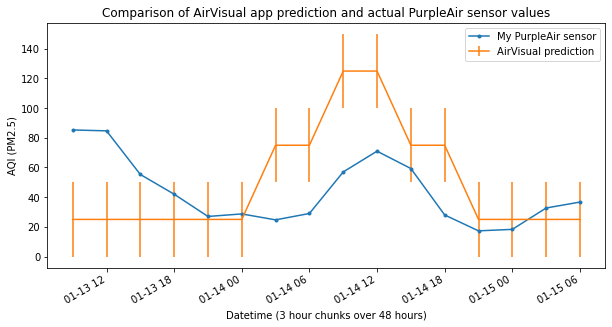

**The prediction from the AirVisual app is only correct half of the time, despite having enormous error bars ($\pm$25 in AQI units). It fails to predict the lunchtime peak on 1/13/22, and overpredicts the peak on 1/14/22.**

In [18]:
# Test of AirVisual prediction vs. the actual reading of my sensor over a 48-hour period

airVisual = [25,25,25,25,25,25,75,75,125,125,75,75,25,25,25,25]
sensor = [85.3, 84.7, 55.3, 42, 27, 28.7, 24.7, 29, 57, 71, 59.3, 28, 17.3, 18.3, 32.7, 36.7]
dates = pd.date_range(start='2022-01-13 09:00:00', end='2022-01-15 06:00:00', periods=16)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates,sensor, '.-', label='My PurpleAir sensor')
ax.errorbar(dates,airVisual,25,label='AirVisual prediction')
fig.autofmt_xdate()
ax.set_title('Comparison of AirVisual app prediction and actual PurpleAir sensor values')
ax.set_xlabel('Datetime (3 hour chunks over 48 hours)')
ax.set_ylabel('AQI (PM2.5)')
ax.legend()
plt.show()

display(Markdown('**The prediction from the AirVisual app is only correct half of the time, despite having enormous error bars ($\pm$25 in AQI units). It fails to predict the lunchtime peak on 1/13/22, and overpredicts the peak on 1/14/22.**'))

In [19]:
# Perform a simple prediction of Santiago's AQI using Prophet
# Prophet requires a df (named 'df') with columns named 'ds' (datestamp) and 'y' (numeric measurement to be forecast)
# Instantiate model and fit data (takes 2-3 min)
m = Prophet()
m.fit(df_prophet)

Initial log joint probability = -83.2699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        530143    0.00369801       33136.9           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        530362    0.00125525       17781.6           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        530448    0.00945238       23564.7           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        530534     0.0191821       26321.9           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        530649    0.00166822       11971.4           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha  

   530724    0.00767049       38729.4      0.4965           1      699   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        530763   4.01665e-05       2451.01           1           1      812   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        530778    0.00108352       10643.4           1           1      928   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        530793   8.53066e-05       3461.83       0.139           1     1043   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        530826    0.00607626       8598.85      0.4174           1     1155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        530892    0.00142292       12970.2           1           1     1267   
    Iter      log prob        |

In [20]:
# Make future df (predict for 1 week) TODO
future = m.make_future_dataframe(periods=7*24, freq='H')

In [21]:
# Make forecast (takes 1 minute)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
160602,2022-04-10 19:00:00,12.830640,-10.606884,37.664400
160603,2022-04-10 20:00:00,14.231023,-8.095639,38.839334
160604,2022-04-10 21:00:00,15.375564,-9.041476,38.215325
160605,2022-04-10 22:00:00,16.436532,-5.957664,38.286743
160606,2022-04-10 23:00:00,17.474707,-6.337267,39.454726


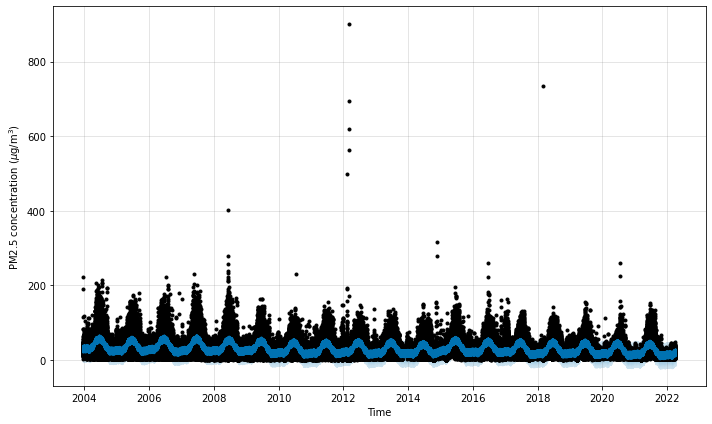

In [22]:
# Full model fit + data (plus tiny 1-week forecast at the end)
fig1 = m.plot(forecast, xlabel='Time', ylabel='PM2.5 concentration ($\mu$g/m$^3$)')

In [23]:
# Plot forecast for a week
# TODO

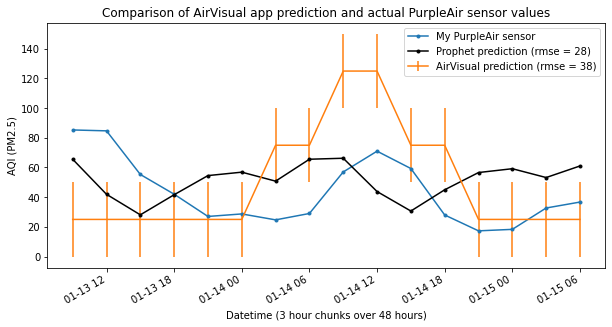

**The Prophet model fits the PurpleAir data much better than the AirVisual prediction.**

In [24]:
# Test of AirVisual prediction vs. the actual reading of my sensor over a 48-hour period
t_min = '2022-01-13 09:00:00'
t_max = '2022-01-15 06:00:00'
airVisual = [25,25,25,25,25,25,75,75,125,125,75,75,25,25,25,25]
sensor = [85.3, 84.7, 55.3, 42, 27, 28.7, 24.7, 29, 57, 71, 59.3, 28, 17.3, 18.3, 32.7, 36.7]
dates = pd.date_range(start=t_min, end=t_max, periods=16)

# Add the model fit to the plot now
values_model = forecast[['ds','yhat']][(forecast['ds'] >= t_min) & (forecast['ds'] <= t_max)]
values_model = values_model.set_index('ds')
values_model = values_model.resample('3h').mean()
# Convert model values (concentration) to PM2.5 AQI
values_model = [calcAQI(concentration) for concentration in values_model['yhat']]

# Calculate rmse
rmse_airVisual = round(rmse(sensor,airVisual))
rmse_model = round(rmse(sensor,values_model))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates,sensor, '.-', label='My PurpleAir sensor')
ax.errorbar(dates,airVisual,25,label='AirVisual prediction (rmse = {0})'.format(rmse_airVisual))
ax.plot(dates,values_model, 'k.-', label='Prophet prediction (rmse = {0})'.format(rmse_model))
fig.autofmt_xdate()
ax.set_title('Comparison of AirVisual app prediction and actual PurpleAir sensor values')
ax.set_xlabel('Datetime (3 hour chunks over 48 hours)')
ax.set_ylabel('AQI (PM2.5)')
ax.legend()
plt.show()

display(Markdown('**The Prophet model fits the PurpleAir data much better than the AirVisual prediction.**'))

**The Prophet model fits the data much better in the summer.<br>In the winter, other variables (rain, erratic wind) come into play.**

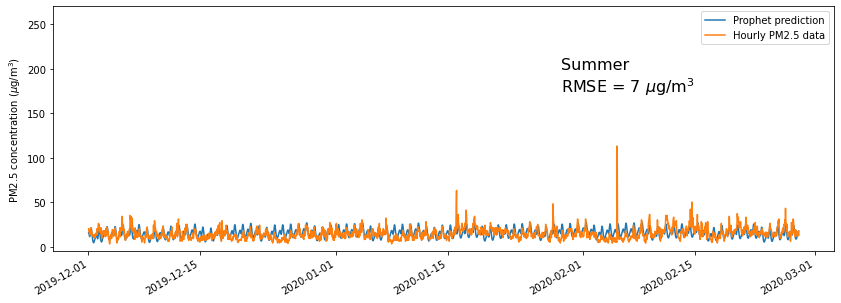

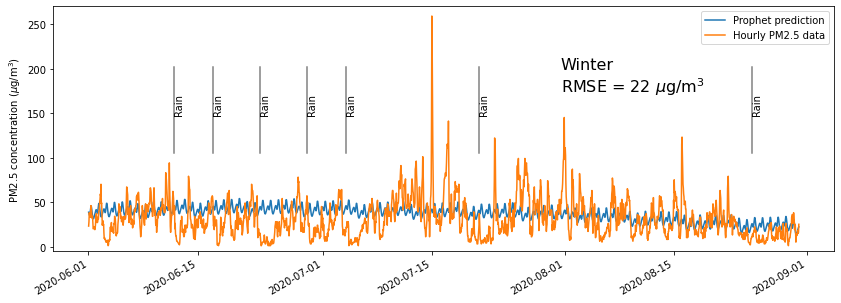

In [25]:
for i,dates in enumerate( [['2019-12-1','2020-2-28'],['2020-6-1','2020-8-31']] ) :
    t_min = dates[0]
    t_max = dates[1]
    # From model
    dates_model = forecast['ds'][(forecast['ds'] > t_min) & (forecast['ds'] <= t_max)]
    values_model = forecast['yhat'][(forecast['ds'] > t_min) & (forecast['ds'] <= t_max)]
    # Actual data
    values = df_tot['pm2.5'][(df_tot.index > t_min) & (df_tot.index <= t_max)]

    # Plot comparison
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_ylabel('PM2.5 concentration ($\mu$g/m$^3$)')
    ax.set_ylim(-5,270)
    ax.plot(dates_model,values_model, '-', label='Prophet prediction')
    ax.plot(values, '-', label='Hourly PM2.5 data')
    fig.autofmt_xdate()
    ax.legend()
    
    # Calculate RMSE of values vs. model
    error = rmse(values, values_model)
    
    if i==0 :
        plt.annotate('Summer\nRMSE = {0} $\mu$g/m$^3$'.format(round(error)), xy=(0.65, 0.65), xycoords='axes fraction', fontsize=16)
    elif i==1 :
        plt.annotate('Winter\nRMSE = {0} $\mu$g/m$^3$'.format(round(error)), xy=(0.65, 0.65), xycoords='axes fraction', fontsize=16)
        for date in [dt.datetime(2020, 6, 12), dt.datetime(2020, 6, 17), dt.datetime(2020, 6, 23), dt.datetime(2020, 6, 29), dt.datetime(2020, 7, 4), dt.datetime(2020, 7, 21), dt.datetime(2020, 8, 25)] :
            plt.axvline(date, ymin=0.4, ymax=0.75, color='gray')    
            plt.annotate('Rain', xy=(date,150), rotation=90)
           
display(Markdown('**The Prophet model fits the data much better in the summer.<br>In the winter, other variables (rain, erratic wind) come into play.**'))    

In [26]:
# TO DO: 
# Remove the annual, weekly, and daily signals and search for anomalies (can I pull out the BBQs from the downstairs neighbors?)
# Go beyond the Prophet model and include all of the Santiago data (PM2.5, PM10, temp, pressure humidity, wind speed, wind dir) vs. just some of it (e.g., removing wspd and wdir) to see which variables provide better predictive power.

In [27]:
# For testing: print URL of desired variable, paste into browser, and open downloaded data file
#pm25['url']
#pm10['url']
#wspd['url']
#rhum['url']
temp['url']

'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/D14/Met/TEMP//horario_000.ic&from=031215&to=220404&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='

**The model shows the following: <br>(1) The PM2.5 concentration is decreasing year over year<br>(2) The AQI gets worse as the week progresses<br>(3) The AQI is worse in the winter (Jun-Aug in the southern hemisphere)<br>(4) the AQI is best around 4 p.m.**

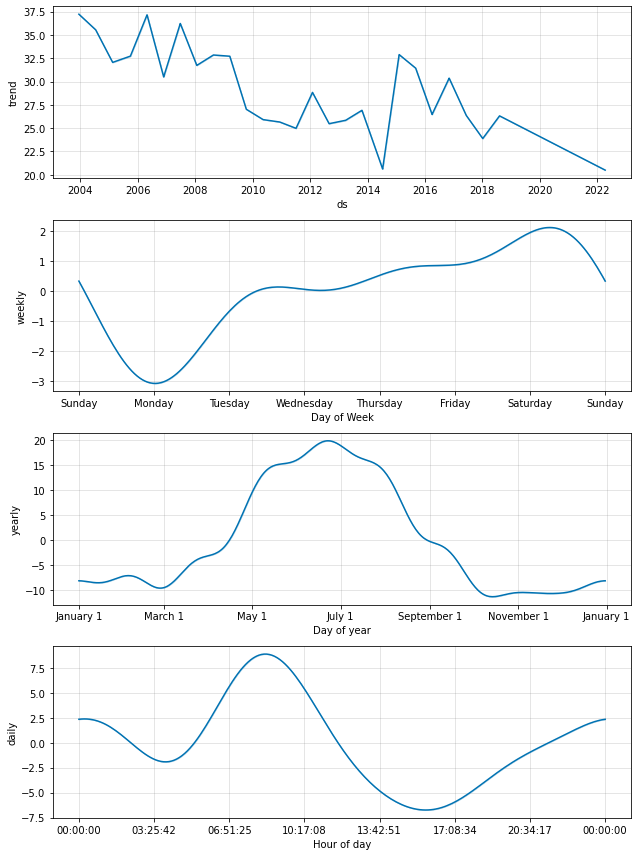

In [28]:
# Static plot of components
fig2 = m.plot_components(forecast)
display(Markdown('**The model shows the following: <br>(1) The PM2.5 concentration is decreasing year over year<br>(2) The AQI gets worse as the week progresses<br>(3) The AQI is worse in the winter (Jun-Aug in the southern hemisphere)<br>(4) the AQI is best around 4 p.m.**'))

In [29]:
##### Interactive plotly plots seem to make the notebook crash

# Interactive plotly plot of prediction
# plot_plotly(m, forecast)

# For plotting interactive plot of components
# plot_components_plotly(m, forecast)

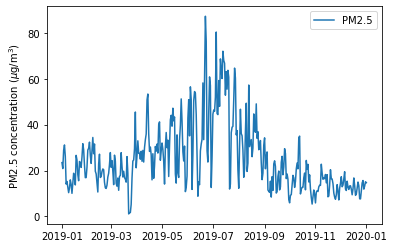

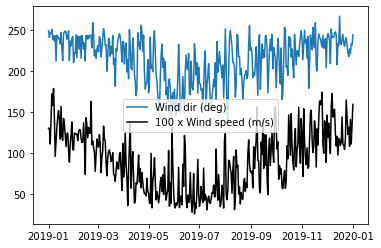

In [30]:
# Other exploratory plots
# Top: resampled (daily) PM2.5 concentration as a function of time in 2019 (pre-pandemic year)
# Bottom: resampled (daily) wind direction (deg) and wind speed (m/s, rescaled by 100x) with the same time range
##### THERE ARE CLEAR CORRELATIONS BETWEEN PM2.5 CONCENTRATION AND BOTH WIND DIRECTION AND WIND SPEED.  
##### IN THE WINTER THE WIND DIES DOWN, AND THUS THE POLLUTION IS NOT BLOWN AWAY.
##### THE CHANGE IN WIND DIRECTION FROM THE WEST=270 DEG IN THE SUMMER VS. THE SOUTH=180 DEG IN THE WINTER
#####    DESERVES FURTHER EXPLORATION.

t_min='2019-01-01'
t_max='2020-01-01'
plt.figure()
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('D').mean(),'-', label='PM2.5')
plt.ylabel('PM2.5 concentration ($\mu$g/m$^3$)')
plt.legend()
plt.figure()
plt.plot(df_tot['wdir'][t_min:t_max].resample('D').mean(),'-', label='Wind dir (deg)')
plt.plot(100*df_tot['wspd'][t_min:t_max].resample('D').mean(),'k-', label='100 x Wind speed (m/s)')
plt.legend()